In [ ]:
try:
  import idi
except ImportError:
    print("IDI not installed. Installing...")
    %pip install -q git+https://github.com/fzimmermann89/idi

In [2]:
import idi.simulation
import idi.reconstruction
import idi.util

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import h5py
from tqdm import tqdm

%matplotlib inline

## Settings

In [3]:
excitation = 1e7 # emitters per um^3
thickness = 4  # in um
focus_fwhm = (0.25, 0.25)  # in um
attenuation_length = np.inf # in um
object_rotation_angles = np.array([0, 0, 0]) / 180 * np.pi # rotates object in focus


pixelsize = 75  # in um
detector_size = 128 # pixels
detector_distance = 58.3  # in cm
detector_offset_x = 75*1000 # in um
detector_offset_y = 75*1000 # in um
detector_angles = np.array([0,0]) / 180 * np.pi # rotates detector distance, for example for detector in 90 degree angle


n_img = 5 # number of images to simulate
E = 4950  # in ev
random_phase = True # random phase for each emitter (idi)
random_positions = True # random emitter positions in the object in each image
n_modes = 2  # number of overlaid modes due to coherence etc
n_photons = np.inf # photons on the detector. # np.inf: no noise. # -1: calculate from geometry and excitation


outputpath = Path(f"output-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.h5") # output filename



In [4]:
# change simobject to a different object if you want to simulate a different object
simobject = idi.simulation.simobj.foil(E=E, excitation=excitation, thickness=thickness,fwhm=focus_fwhm,attenuationlength=np.inf,rho=(2,2), rotangles=object_rotation_angles)
simobject.rndPos=random_positions
simobject.rndPhase=random_phase

if n_photons == -1:
    n_photons = simobject.N * ((pixelsize * detector_size)**2 / (4 * np.pi * (detector_distance * 1e4)**2))

print(f"{simobject.N:.2e} emitters in the object. {n_photons:.2e} photons on the detector.")


2.83e+06 emitters in the object. inf photons on the detector.


#### Visualize Object

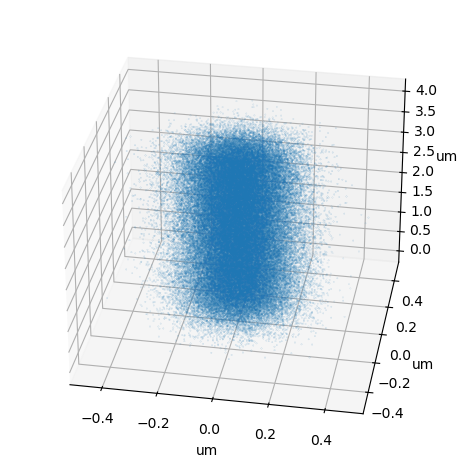

In [5]:

pos = simobject.get2()[0]
fig = plt.figure()
ax = plt.axes(projection='3d')
if len(pos) > 1e5:
    print("Warning: too many emitters to plot, randomly choosing subset")
    pos=pos[np.random.choice(len(pos), int(1e5), replace=False)]
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=0.01)
ax.set_xlabel('um')
ax.set_ylabel('um')
ax.set_zlabel('um')
ax.view_init(30, -80)
plt.tight_layout()
plt.show()

## Simulation

In [6]:

with h5py.File(outputpath, 'w') as file:
        file.attrs.update({
                "excitation": excitation,
                "thickness": thickness,
                "focus_fwhm": focus_fwhm,
                "attenuation_length": attenuation_length,
                "object_rotation_angles": object_rotation_angles,
                "pixelsize": pixelsize,
                "detector_size": detector_size,
                "detector_distance": detector_distance,
                "detector_offset_x": detector_offset_x,
                "detector_offset_y": detector_offset_y,
                "detector_angles": detector_angles,
                "E": E,
                "random_phase": random_phase,
                "random_positions": random_positions,
                "n_modes": n_modes,
                "n_photons": n_img,
                "n_img": n_img,
            })
        file['simobject_positions'] = simobject.get2()[0]
        dset_wavefield = file.create_dataset(
            "wavefields",
            shape=(1, detector_size, detector_size),
            maxshape=(None, detector_size, detector_size),
            chunks=(1, detector_size, detector_size),
            dtype=np.complex64
        )
 
        correlator = idi.reconstruction.simple.correlator2d()
        generator = idi.simulation.auto.simulate_gen(simobject, detector_size, pixelsize, detector_distance*1e4, detangles=detector_angles, detoffset=(detector_offset_x, detector_offset_y), returngpu=True, settings="single")
        for i_img in tqdm(range(n_img)):
            photons = 0
            for i_mode in range(n_modes or 1):
                wavefield = next(generator)
                dset_wavefield.resize(((len(dset_wavefield)) + 1, detector_size, detector_size))
                dset_wavefield[-1] = wavefield.astype(np.complex64) if isinstance(wavefield, np.ndarray) else wavefield.get().astype(np.complex64)
                intensity = wavefield.real**2 + wavefield.imag**2
                photons = photons + idi.simulation.common.randomphotons(intensity, n_photons)
            correlator.add(photons) 
        file['correlations_mean'] = correlator.mean
        file['correlations_std'] = correlator.std

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


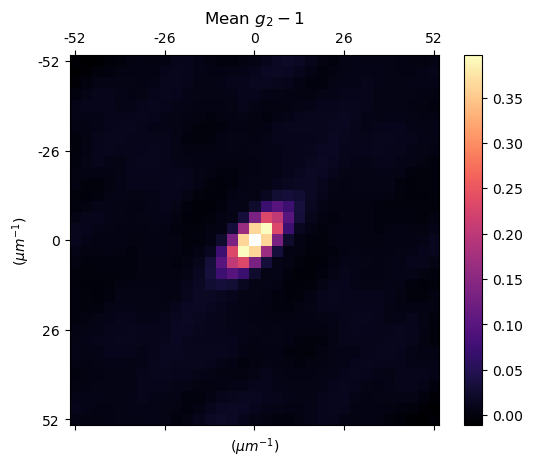

In [7]:
idi.util.plot_2d(correlator.mean-1, mask_center=True,crop=(33,33), E=E, detz=detector_distance*1e4, pixelsize=pixelsize, title="Mean $g_2-1$", q_ticks=True);


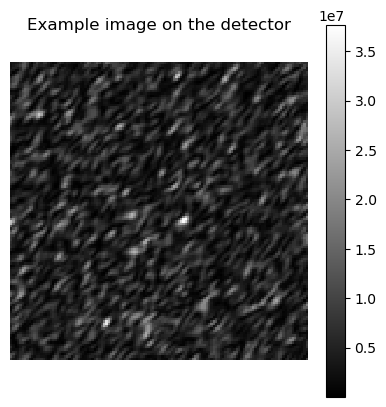

In [8]:
if not isinstance(photons, np.ndarray):
    photons = photons.get()
plt.matshow(photons,cmap="gray")
plt.colorbar()
plt.axis("off")
plt.title("Example image on the detector");
